# The synthetities to are all 8 combinations of the following options:

- Underlying graph:

Erdos-Renyi or Power Law Distribution

- Attack type:

DDOS against a single node or a Biclique imputation

- New attackers toggle:

Attack consisting solely of newly-created nodes or partially of already-present nodes (zombies)

## Not yet used in the process at all

In [1]:
#from thesis_library import *
import matplotlib.pyplot as plt
import networkx as nx
import random

def swap(edge):
    return (edge[1], edge[0])

def purge_graph(g: nx.Graph) -> nx.Graph:
    '''Getting rid of connected components of size 2'''
    
    g2 = g.copy()
    for cc in list(nx.connected_components(g2)):
        if len(cc) == 2:
            for node in cc:
                g2.remove_node(node)
    
    #Relabels to integers in order!
    relabel_dict = {node: i for (node, i) in zip(g2.nodes, range(len(g2.nodes)))}
    g2 = nx.relabel_nodes(g2, relabel_dict)
    
    return g2

### 4 Attack Functions:

In [2]:
def create_ddos_new_nodes(G: nx.Graph, n_attack: int, p_attack: float, attacked_node = None) -> tuple:
    '''
    Attacks a given G (one node in it) with n_attack new nodes that all send p_attack edges
    
    returns G and the list of enomalous edges to get them the proper labels
    '''
    
    if attacked_node is None:
        attacked_node = random.sample(list(G.nodes), 1)[0]
    
    highest_node = max(list(G.nodes))
    G.add_nodes_from([i for i in range(highest_node+1, highest_node+1+n_attack)])
    
    edges_to_add = [(attacked_node, i) for i in range(highest_node+1, highest_node+1+n_attack) \
                    if random.uniform(0, 1) < p_attack]
    G.add_edges_from(edges_to_add, anomaly=True)
    
    return G, edges_to_add

In [3]:
def create_ddos_used_nodes(G: nx.Graph, n_attack: int, p_attack: float, attacked_node = None) -> tuple:
    '''
    Selects randomly a set of n_attack nodes from nodes that are already in the network
    Uses them to attack a given node with p_m probability for each edge
    
    returns G and the list of enomalous edges to get them the proper labels'''
    
    if attacked_node is None:
        attacked_node = random.sample(list(G.nodes), 1)[0]
    
    used_nodes = random.sample(list(G.nodes), n_attack)
    edges_to_add = [(attacked_node, i) for i in used_nodes if random.uniform(0, 1) < p_attack]
    G.add_edges_from(edges_to_add)
    
    return G, edges_to_add

In [4]:
def create_biclique_new_nodes(G: nx.Graph, n_attack: int, p_attack: float, split: float) -> float:
    '''
    Creates n_attack new nodes in the network
    Splits them in split:1-split groups and creates a p_attack probability biclique between them
    
    returns G and the list of enomalous edges to get them the proper labels
    '''
    
    highest_node = max(list(G.nodes))
    new_nodes = [i for i in range(highest_node+1, highest_node+1+n_attack)]
    G.add_nodes_from(new_nodes)
    
    new_nodes_1, new_nodes_2 = new_nodes[:int(n_attack*split)], new_nodes[int(n_attack*split):]
    
    edges_to_add = [(i, j) for i in new_nodes_1 for j in new_nodes_2 if random.uniform(0, 1) < p_attack]
    G.add_edges_from(edges_to_add)
    
    return G, edges_to_add

In [5]:
def create_biclique_used_nodes(G: nx.Graph, n_attack: int, p_attack: float, split: float) -> float:
    '''
    Creates (1-split)*n_attack new nodes in the network
    Selects split*n_attack nodes from the network
    Creates a biclique with p_attack of each attacking edge happening
    split=0.3 would mean 30% of the attackers are old nodes, 70% are newly-created nodes
    
    returns G and the list of enomalous edges to get them the proper labels
    '''
    
    attacked_nodes = random.sample(list(G.nodes), int(n_attack*split))
    
    highest_node = max(list(G.nodes))
    new_nodes = [i for i in range(highest_node+1, highest_node+1+int((1.0-split)*n_attack))]
    G.add_nodes_from(new_nodes)
    
    edges_to_add = [(i, j) for i in attacked_nodes for j in new_nodes if random.uniform(0, 1) < p_attack]
    G.add_edges_from(edges_to_add)
    
    return G, edges_to_add

## Dataset + attack creation function:

### TO DO: change the way the return is handled, i.e. format it to be consistent with Yao's data format

In [6]:
def create_dataset(underlying: str, attack_type: str, new: bool, n: int, p: float, m: int, n_attack: int,
                   p_attack: float, split: float, prune_2: bool):
    '''
    underlying:                  ["ER" or "PL"] for Erdos-Renyi or Power Law
    attack_type:                 ["DDOS" or "Biclique"]
    new:                         if True, imput all new nodes for the attack. If False, re-use alread-present nodes
    n:                           number of nodes
    p (for underlying=ER):       the probability of an edge happening
    p (for underlying=PL):       the probability of a triangle occurring after 1 random new edge
    m (for underlying=PL):       the number of random edges to add for each new node
    n_attack (for new=True):     the number of additional nodes
    p_attack:                    the probability of each possible attack edge happening
    split (for Biclique):        the split size of the biclique structure (like 1:9, 2:8 etc.), pass a float in (0, 1)
    prune_2:                     whether to remove connected components of size 2 from the final graph
    '''
    
    #Determining the underlying graph's structure:
    if underlying == "ER":
        G = nx.erdos_renyi_graph(n=n, p=p)
    elif underlying == "PL":
        G = nx.powerlaw_cluster_graph(n=n, m=m, p=p, seed=2137)
    else:
        raise ValueError("underlying must be one of: ['ER', 'PL']")
    
    #Setting all edges' "anomaly" attribute to False:
    nx.set_edge_attributes(G, values=False, name='anomaly')
    
    #Performing the attack. All new edges have "anomaly" attribute as True:
    if attack_type == 'DDOS' and new is True:
        G, new_edges = create_ddos_new_nodes(G, n_attack=n_attack, p_attack=p_attack)
        
    elif attack_type == 'DDOS' and new is False:
        G, new_edges = create_ddos_used_nodes(G, n_attack=n_attack, p_attack=p_attack)
        
    elif attack_type == 'Biclique' and new is True:
        G, new_edges = create_biclique_new_nodes(G, n_attack=n_attack, p_attack=p_attack, split=split)
    
    elif attack_type == 'Biclique' and new is False:
        G, new_edges = create_biclique_used_nodes(G, n_attack=n_attack, p_attack=p_attack, split=split)
    
    else:
        raise ValueError("attack_type must be one of ['DDOS', 'Biclique'] and new is a bool")
    
    #Pruning away the nodes that have 0 edges (for visualization purposes mostly):
    G.remove_nodes_from(tuple(nx.isolates(G)))
    
    edges = list(G.edges)
    
#     #Pruning away pairs of nodes (connected components of size 2):
#     G = purge_graph(G)
    
    #Returning G and data, label in the way Yao formats her dataset:
    return G, edges, [int((edges[i] in new_edges) or (swap(edges[i]) in new_edges)) for i in range(len(edges))]

## Tests:

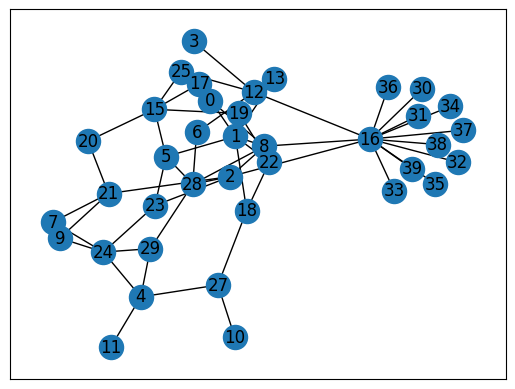

In [7]:
G, data, label = create_dataset(underlying='ER', attack_type='DDOS', new=True, n=30, p=0.1, m=None, \
                              n_attack=10, p_attack=1.0, split=None, prune_2=True)

nx.draw_networkx(G)

In [20]:
len(G.edges)

42

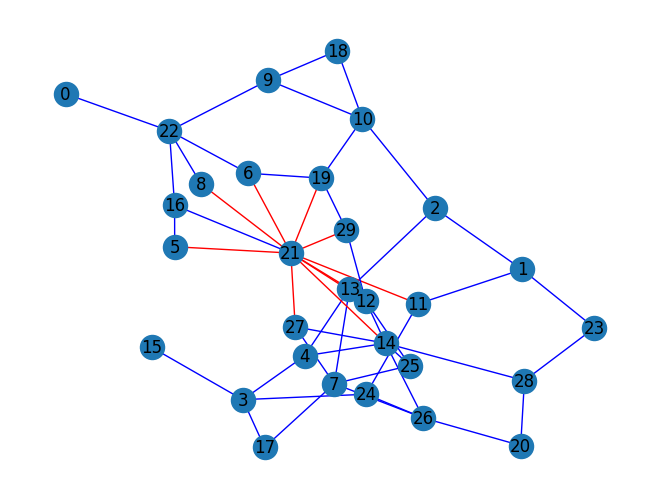

In [21]:
G, data, label = create_dataset(underlying='ER', attack_type='DDOS', new=False, n=30, p=0.1, m=None, \
                              n_attack=10, p_attack=1.0, split=None, prune_2=True)

color_map = ['blue' if x==0 else 'red' for x in label]
nx.draw(G, edge_color=color_map, with_labels=True)
plt.show()

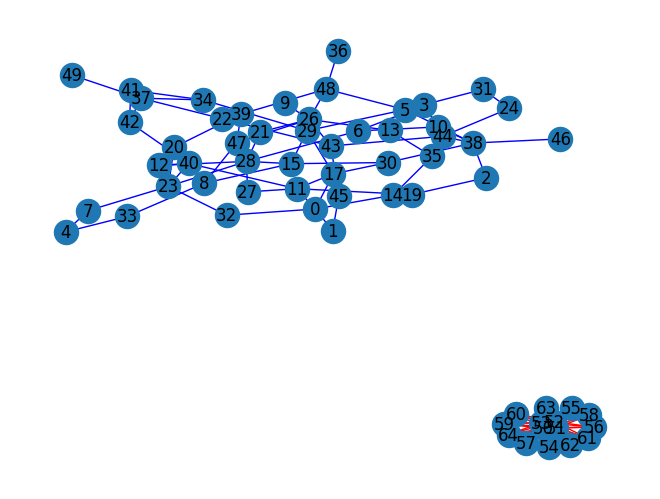

In [26]:
G, data, label = create_dataset(underlying='ER', attack_type='Biclique', new=True, n=50, p=0.08, m=None, \
                              n_attack=15, p_attack=1.0, split=0.3, prune_2=True)

color_map = ['blue' if x==0 else 'red' for x in label]
nx.draw(G, edge_color=color_map, with_labels=True)
plt.show()

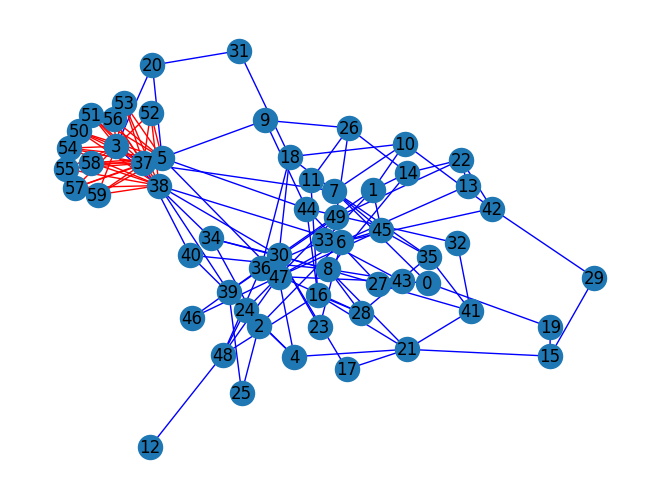

In [30]:
G, data, label = create_dataset(underlying='ER', attack_type='Biclique', new=False, n=50, p=0.08, m=None, \
                              n_attack=15, p_attack=1.0, split=0.3, prune_2=True)

color_map = ['blue' if x==0 else 'red' for x in label]
nx.draw(G, edge_color=color_map, with_labels=True)
plt.show()

In [ ]:
G, data, label = create_dataset(underlying='PL', attack_type='DDOS', new=True, n=50, p=0.22, m=4, \
                              n_attack=15, p_attack=1.0, split=None, prune_2=True)

color_map = ['blue' if x==0 else 'red' for x in label]
nx.draw(G, edge_color=color_map, with_labels=True)
plt.show()

In [ ]:
G, data, label = create_dataset(underlying='PL', attack_type='DDOS', new=False, n=50, p=0.22, m=4, \
                              n_attack=15, p_attack=1.0, split=None, prune_2=True)

nx.draw_networkx(G)

In [ ]:
G, data, label = create_dataset(underlying='PL', attack_type='Biclique', new=True, n=50, p=0.22, m=4, \
                              n_attack=15, p_attack=1.0, split=0.3, prune_2=True)

nx.draw_networkx(G)

In [ ]:
G, data, label = create_dataset(underlying='PL', attack_type='Biclique', new=False, n=50, p=0.22, m=4, \
                              n_attack=15, p_attack=1.0, split=0.3, prune_2=True)

nx.draw_networkx(G)